In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        exit(-1)

In [4]:
train_dir = os.path.join('HAM10000', 'train_dir')
test_dir = os.path.join('HAM10000', 'test_dir')

In [3]:
# data_pd = pd.read_csv('HAM10000_metadata.csv')
# data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [5]:
# df_count = data_pd.groupby('lesion_id').count()
# df_count.head()

,image_id,dx,dx_type,age,sex,localization,dataset
lesion_id,,,,,,,
HAM_0000000,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1


In [6]:
# df_count = df_count[df_count['dx'] == 1]
# df_count.reset_index(inplace=True)

In [7]:
# def duplicates(x):
#     unique = set(df_count['lesion_id'])
#     if x in unique:
#         return 'no' 
#     else:
#         return 'duplicates'

In [8]:
# data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
# data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates


In [9]:
# df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [10]:
# train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [11]:
# def identify_trainOrtest(x):
#     test_data = set(test_df['image_id'])
#     if str(x) in test_data:
#         return 'test'
#     else:
#         return 'train'

# #creating train_df
# data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
# train_df = data_pd[data_pd['train_test_split'] == 'train']
# train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates,train


In [12]:
# test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
4515,HAM_0003527,ISIC_0029874,nv,follow_up,45.0,male,lower extremity,vidir_molemax,no
6381,HAM_0003780,ISIC_0027123,nv,follow_up,30.0,female,back,vidir_molemax,no
5026,HAM_0006054,ISIC_0030982,nv,follow_up,55.0,female,lower extremity,vidir_molemax,no
5847,HAM_0000538,ISIC_0030650,nv,follow_up,45.0,male,lower extremity,vidir_molemax,no
6304,HAM_0002195,ISIC_0031576,nv,follow_up,50.0,male,upper extremity,vidir_molemax,no


In [ ]:
# # Image id of train and test images
# train_list = list(train_df['image_id'])
# test_list = list(test_df['image_id'])

In [14]:
# len(test_list),len(train_list)

828

In [15]:
# # Set the image_id as the index in data_pd
# data_pd.set_index('image_id', inplace=True)

In [ ]:
train_dir = os.path.join('HAM10000', 'train_dir')
test_dir = os.path.join('HAM10000', 'test_dir')

In [16]:
# os.mkdir(train_dir)
# os.mkdir(test_dir)

In [17]:
# targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [18]:
# for i in targetnames:
#   directory1=train_dir+'/'+i
#   directory2=test_dir+'/'+i
#   os.mkdir(directory1)
#   os.mkdir(directory2)

In [19]:
# for image in train_list:
#     file_name = image+'.jpg'
#     label = data_pd.loc[image, 'dx']

#     # path of source image 
#     source = os.path.join('img10015', file_name)

#     # copying the image from the source to target file
#     target = os.path.join(train_dir, label, file_name)

#     shutil.copyfile(source, target)

In [20]:
# for image in test_list:

#     file_name = image+'.jpg'
#     label = data_pd.loc[image, 'dx']

#     # path of source image 
#     source = os.path.join('img10015', file_name)

#     # copying the image from the source to target file
#     target = os.path.join(test_dir, label, file_name)

#     shutil.copyfile(source, target)

In [23]:
# targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# # Augmenting images and storing them in temporary directories 
# for img_class in targetnames:

#     #creating temporary directories
#     # creating a base directory
#     aug_dir = 'aug_dir'
#     os.mkdir(aug_dir)
#     # creating a subdirectory inside the base directory for images of the same class
#     img_dir = os.path.join(aug_dir, 'img_dir')
#     os.mkdir(img_dir)

#     img_list = os.listdir('HAM10000/train_dir/' + img_class)

#     # Copy images from the class train dir to the img_dir 
#     for file_name in img_list:

#         # path of source image in training directory
#         source = os.path.join('HAM10000/train_dir/' + img_class, file_name)

#         # creating a target directory to send images 
#         target = os.path.join(img_dir, file_name)

#         # copying the image from the source to target file
#         shutil.copyfile(source, target)

#     # Temporary augumented dataset directory.
#     source_path = aug_dir

#     # Augmented images will be saved to training directory
#     save_path = 'HAM10000/train_dir/' + img_class

#     # Creating Image Data Generator to augment images
#     datagen = tf.keras.preprocessing.image.ImageDataGenerator(

#         rotation_range=180,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         vertical_flip=True,
#         fill_mode='nearest'

#     )

#     batch_size = 50

#     aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(299, 299),batch_size=batch_size)

#     # Generate the augmented images
#     aug_images = 8000 

#     num_files = len(os.listdir(img_dir))
#     num_batches = int(np.ceil((aug_images - num_files) / batch_size))

#     # creating 8000 augmented images per class
#     for i in range(0, num_batches):
#         images, labels = next(aug_datagen)

#     # delete temporary directory 
#     shutil.rmtree('aug_dir')


Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [16]:
train_path = 'HAM10000/train_dir'
test_path = 'HAM10000/test_dir'
batch_size = 16

In [18]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [19]:
image_size = 299
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 51699 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


In [20]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()
 

In [21]:

irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",

)

# Excluding the last 28 layers of the model.
conv = irv2.layers[-28].output


2022-04-19 16:26:13.277508: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-19 16:26:13.278031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 16:26:13.278776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 16:26:13.279400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Soft Attention

In [22]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


In [23]:

output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=irv2.input, outputs=output)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [25]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [42]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath ='IRV2+SA.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)




In [43]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=30, min_delta=0.001)
history = model.fit(train_batches,
                    steps_per_epoch=(9187/10),#len(train_df)
                    epochs=150,
                    verbose=2,
                    validation_data=test_batches,validation_steps=len(test_df)/batch_size,callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/150
918/918 - 205s - loss: 0.1831 - accuracy: 0.9498 - val_loss: 0.4878 - val_accuracy: 0.8647
Epoch 2/150
918/918 - 206s - loss: 0.1646 - accuracy: 0.9555 - val_loss: 0.4189 - val_accuracy: 0.8937
Epoch 3/150
918/918 - 205s - loss: 0.1725 - accuracy: 0.9538 - val_loss: 0.3933 - val_accuracy: 0.8865
Epoch 4/150
918/918 - 206s - loss: 0.1322 - accuracy: 0.9665 - val_loss: 0.3900 - val_accuracy: 0.9046
Epoch 5/150
918/918 - 206s - loss: 0.1484 - accuracy: 0.9596 - val_loss: 0.6799 - val_accuracy: 0.8466
Epoch 6/150
918/918 - 206s - loss: 0.1378 - accuracy: 0.9629 - val_loss: 0.5195 - val_accuracy: 0.9058
Epoch 7/150
918/918 - 205s - loss: 0.1176 - accuracy: 0.9690 - val_loss: 0.4819 - val_accuracy: 0.8744
Epoch 8/150
918/918 - 206s - loss: 0.1201 - accuracy: 0.9665 - val_loss: 0.3960 - val_accuracy: 0.9034
Epoch 9/150
918/918 - 205s - loss: 0.1010 - accuracy: 0.9737 - val_loss: 0.6082 - val_accuracy: 0.8816
Epoch 10/150
918/918 - 206s - loss: 0.1375 - accuracy: 0.9657 - val_loss:

KeyboardInterrupt: 

In [44]:
from tensorflow.keras import models
model.load_weights("IRV2+SA.hdf5")

In [45]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

In [46]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.71      0.43      0.54        23
         bcc       0.86      0.92      0.89        26
         bkl       0.78      0.59      0.67        66
          df       0.33      0.83      0.48         6
         mel       0.65      0.50      0.57        34
          nv       0.94      0.98      0.96       663
        vasc       1.00      0.70      0.82        10

    accuracy                           0.91       828
   macro avg       0.75      0.71      0.70       828
weighted avg       0.90      0.91      0.90       828



In [47]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.9044426851656376
Recall: 0.9057971014492754
Accuracy: 0.9057971014492754
weighted Roc score: 0.9685589145888256


In [48]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='macro')))

Precision: 0.7543526462463339
Recall: 0.7084967888036943
Accuracy: 0.9057971014492754
Macro Roc score: 0.972059512085834


In [49]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.9057971014492754
Recall: 0.9057971014492754
Accuracy: 0.9057971014492754
Micro Roc score: 0.9896044831851385


In [50]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9632730218741561
The ROC AUC score of bcc is: 0.9982255898714751
The ROC AUC score of bkl is: 0.9465919032848167
The ROC AUC score of df is: 0.9813463098134632
The ROC AUC score of mel is: 0.9449548081197214
The ROC AUC score of nv is: 0.9703916998034645
The ROC AUC score of vasc is: 0.9996332518337409


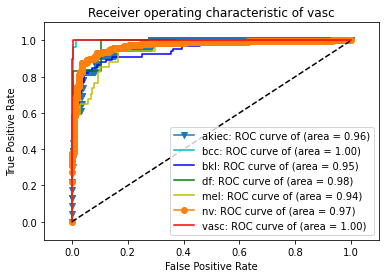

In [51]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()

In [52]:
x_test,y_test=next(test_batches)

In [53]:
sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(x_test)

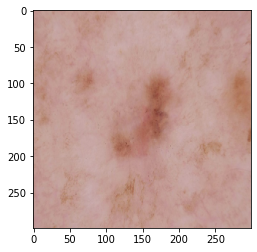

In [54]:
img_idx = 0
t = (x_test + 1)/2 # bring the range between 0,1 from -1,1
plt.imshow(t[img_idx])

In [55]:
sum_attnmap = np.sum(sa_maps[img_idx],0)
sum_attnmap.shape

(8, 8)

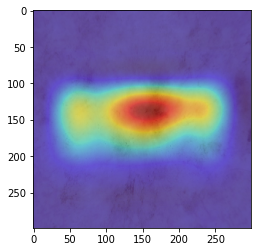

In [56]:
plt.imshow(t[img_idx],alpha=1.0)
plt.imshow(cv2.resize(sum_attnmap,(299,299),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
plt.show()

In [ ]:
# !mv /content/IRV2+SA.hdf5 /content/drive/MyDrive